In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df = pd.read_csv("../../data/processed/customer.csv")
digital_usage_df = pd.read_csv("../../data/processed/digital_usage.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
loans_df = pd.read_csv("../../data/processed/loans.csv")
products_owned_df = pd.read_csv("../../data/processed/products_owned.csv")
transactions_df = pd.read_csv("../../data/processed/transactions.csv")

datasets_info = {
    "campaigns": campaigns_df.shape,
    "customer": customer_df.shape,
    "digital_usage": digital_usage_df.shape,
    "engagement_details": engagement_details_df.shape,
    "loans": loans_df.shape,
    "products_owned": products_owned_df.shape,
    "transactions": transactions_df.shape
}

datasets_info

{'campaigns': (99, 10),
 'customer': (4000, 13),
 'digital_usage': (4000, 9),
 'engagement_details': (16000, 8),
 'loans': (7920, 6),
 'products_owned': (4000, 7),
 'transactions': (5044, 5)}

In [181]:
seed = 5423

In [182]:
missing_values = {
    "Campaigns Data": campaigns_df.isnull().sum(),
    "Customer Data": customer_df.isnull().sum(),
    "Digital Usage Data": digital_usage_df.isnull().sum(),
    "Engagement Details": engagement_details_df.isnull().sum(),
    "Loans Data": loans_df.isnull().sum(),
    "Products Owned": products_owned_df.isnull().sum(),
    "Transactions Data": transactions_df.isnull().sum(),
}

missing_values_df = pd.DataFrame(missing_values)

print(missing_values_df)


                         Campaigns Data  Customer Data  Digital Usage Data  \
acquisition_cost                    0.0            NaN                 NaN   
age                                 NaN            0.0                 NaN   
avg_mobile_time                     NaN            NaN              1080.0   
avg_web_time                        NaN            NaN               480.0   
balance                             NaN            0.0                 NaN   
campaign_duration                   0.0            NaN                 NaN   
campaign_id                         0.0            NaN                 NaN   
campaign_language                   0.0            NaN                 NaN   
campaign_type                       0.0            NaN                 NaN   
channel_used                        NaN            NaN                 NaN   
clicks                             16.0            NaN                 NaN   
conversion_rate                     0.0            NaN          

In [183]:
digital_usage_df.fillna(0, inplace=True)

customer_df.ffill(inplace=True)

transactions_df.fillna(0, inplace=True)
loans_df.fillna(0, inplace=True)
products_owned_df.fillna(0, inplace=True)
engagement_details_df.fillna(0, inplace=True)

In [184]:
#define churn
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])

recent_transaction_cutoff = transactions_df["transaction_date"].max()

inactive_customers = transactions_df[transactions_df["transaction_date"] < (recent_transaction_cutoff - pd.DateOffset(months=12))]["customer_id"].unique()

loans_df["due_date"] = pd.to_datetime(loans_df["due_date"])

loans_df["paid_off_date"] = loans_df["paid_off_date"].replace(0, np.nan)
loans_df["paid_off_date"] = pd.to_datetime(loans_df["paid_off_date"])

closed_loans_customers = loans_df[loans_df["paid_off_date"].notnull()]["customer_id"].unique()

inactive_digital = digital_usage_df[(digital_usage_df["avg_mobile_time"] == 0) & (digital_usage_df["avg_web_time"] == 0)]["customer_id"].unique()

no_products = products_owned_df[products_owned_df.iloc[:, 1:].sum(axis=1) == 0]["customer_id"].unique()

# in at least 2 of the conditions: (dont have transaction in the last 12 months, closed all loans, no digital engagement, no products owned)
# customer_df["churn"] = customer_df["customer_id"].apply(lambda x: 1 if (x in inactive_customers or x in closed_loans_customers or x in inactive_digital or x in no_products) else 0)
customer_df["churn"] = customer_df["customer_id"].apply(lambda x: 1 if ((x in inactive_customers) + (x in closed_loans_customers) + (x in inactive_digital) + (x in no_products) >= 2) else 0)

# print(customer_df.head())
print(customer_df["churn"].value_counts(normalize=True))
print(len(inactive_customers) / len(customer_df))
print(len(inactive_digital) / len(customer_df))
print(len(no_products) / len(customer_df))

churn
0    0.6455
1    0.3545
Name: proportion, dtype: float64
0.3475
0.15975
0.0925


In [ ]:
recent_transactions = transactions_df[transactions_df["transaction_date"] >= (transactions_df["transaction_date"].max() - pd.DateOffset(months=6))]
transaction_counts = recent_transactions.groupby("customer_id")["transaction_id"].count().reset_index()
transaction_counts.columns = ["customer_id", "transaction_count_last_6m"]
customer_df = customer_df.merge(transaction_counts, on="customer_id", how="left").fillna(0)

transaction_amounts = recent_transactions.groupby("customer_id")["transaction_amt"].mean().reset_index()
transaction_amounts.columns = ["customer_id", "avg_transaction_amt"]
customer_df = customer_df.merge(transaction_amounts, on="customer_id", how="left").fillna(0)

loans_df["loan_paid"] = loans_df["paid_off_date"].notnull().astype(int)
loan_repayment_rate = loans_df.groupby("customer_id")["loan_paid"].mean().reset_index()
loan_repayment_rate.columns = ["customer_id", "loan_repayment_ratio"]
customer_df = customer_df.merge(loan_repayment_rate, on="customer_id", how="left").fillna(0)

customer_df["total_products_owned"] = products_owned_df.iloc[:, 1:].sum(axis=1)

customer_df["engagement_score"] = (digital_usage_df["mobile_logins_wk"] + digital_usage_df["web_logins_wk"]).fillna(0)

customer_df = pd.get_dummies(customer_df, columns=["job"], prefix="job")

print(customer_df.head())


   customer_id  age  marital  education  default   balance      debt   income  \
0          166   35  married  secondary        1 -10837.70  38473.44  1456.22   
1          139   32   single  secondary        1  -8163.90  96402.54   597.64   
2          484   24  married  secondary        1  -7492.65   9731.79   822.64   
3          508   32  married  secondary        1  -5520.04  18799.09   340.44   
4          119   27  married  secondary        1  -5071.99  19080.59  1022.64   

   tenure  nps  ...  job_entrepreneur  job_housemaid  job_management  \
0      31    8  ...             False          False           False   
1      20    3  ...             False          False           False   
2      36    0  ...             False          False           False   
3      29    9  ...             False          False           False   
4      36    1  ...             False          False           False   

   job_retired  job_self-employed  job_services  job_student  job_technician  \


In [186]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# features = ["age", "balance", "debt", "income", "tenure", "nps", "dependents", "customer_lifetime_value"]
# features = ["age", "job", "balance", "income", "tenure", "nps", "transaction_count_last_6m", "avg_transaction_amt", "loan_repayment_ratio", "total_products_owned", "engagement_score"]
job_features = [col for col in customer_df.columns if col.startswith("job_")]

# Update the feature list to include all job categories
features = ["age", "balance", "income", "tenure", "nps", 
            "transaction_count_last_6m", "avg_transaction_amt", 
            "loan_repayment_ratio", "total_products_owned", "engagement_score"] + job_features
X = customer_df[features]  
y = customer_df["churn"]   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

model_performance = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Score": [accuracy, precision, recall, f1, roc_auc]
})

print(model_performance)

      Metric     Score
0   Accuracy  0.736250
1  Precision  0.679803
2     Recall  0.485915
3   F1 Score  0.566735
4    ROC-AUC  0.679973


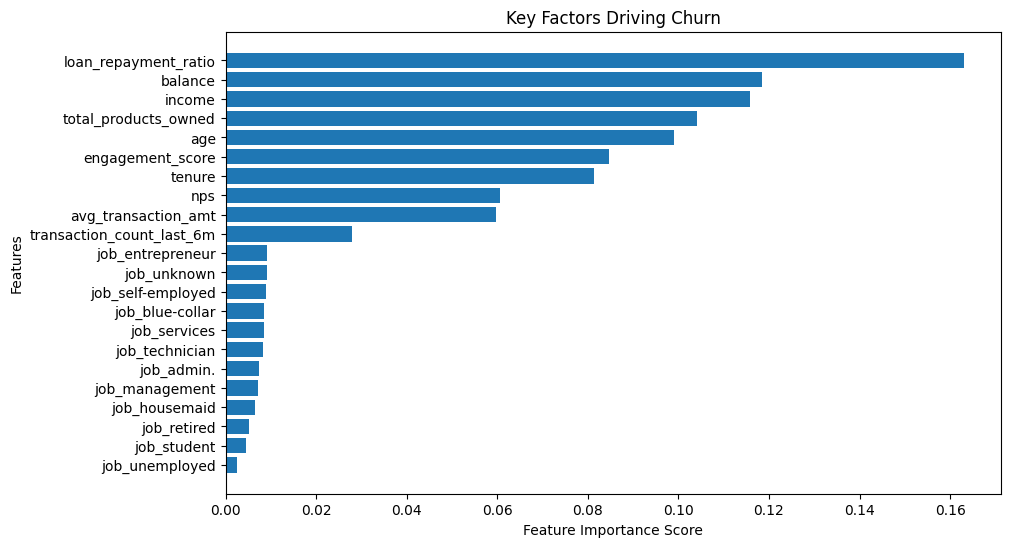

In [187]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = rf_model.feature_importances_
feature_names = np.array(features)

sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], align="center")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Key Factors Driving Churn")
plt.gca().invert_yaxis()  
plt.show()


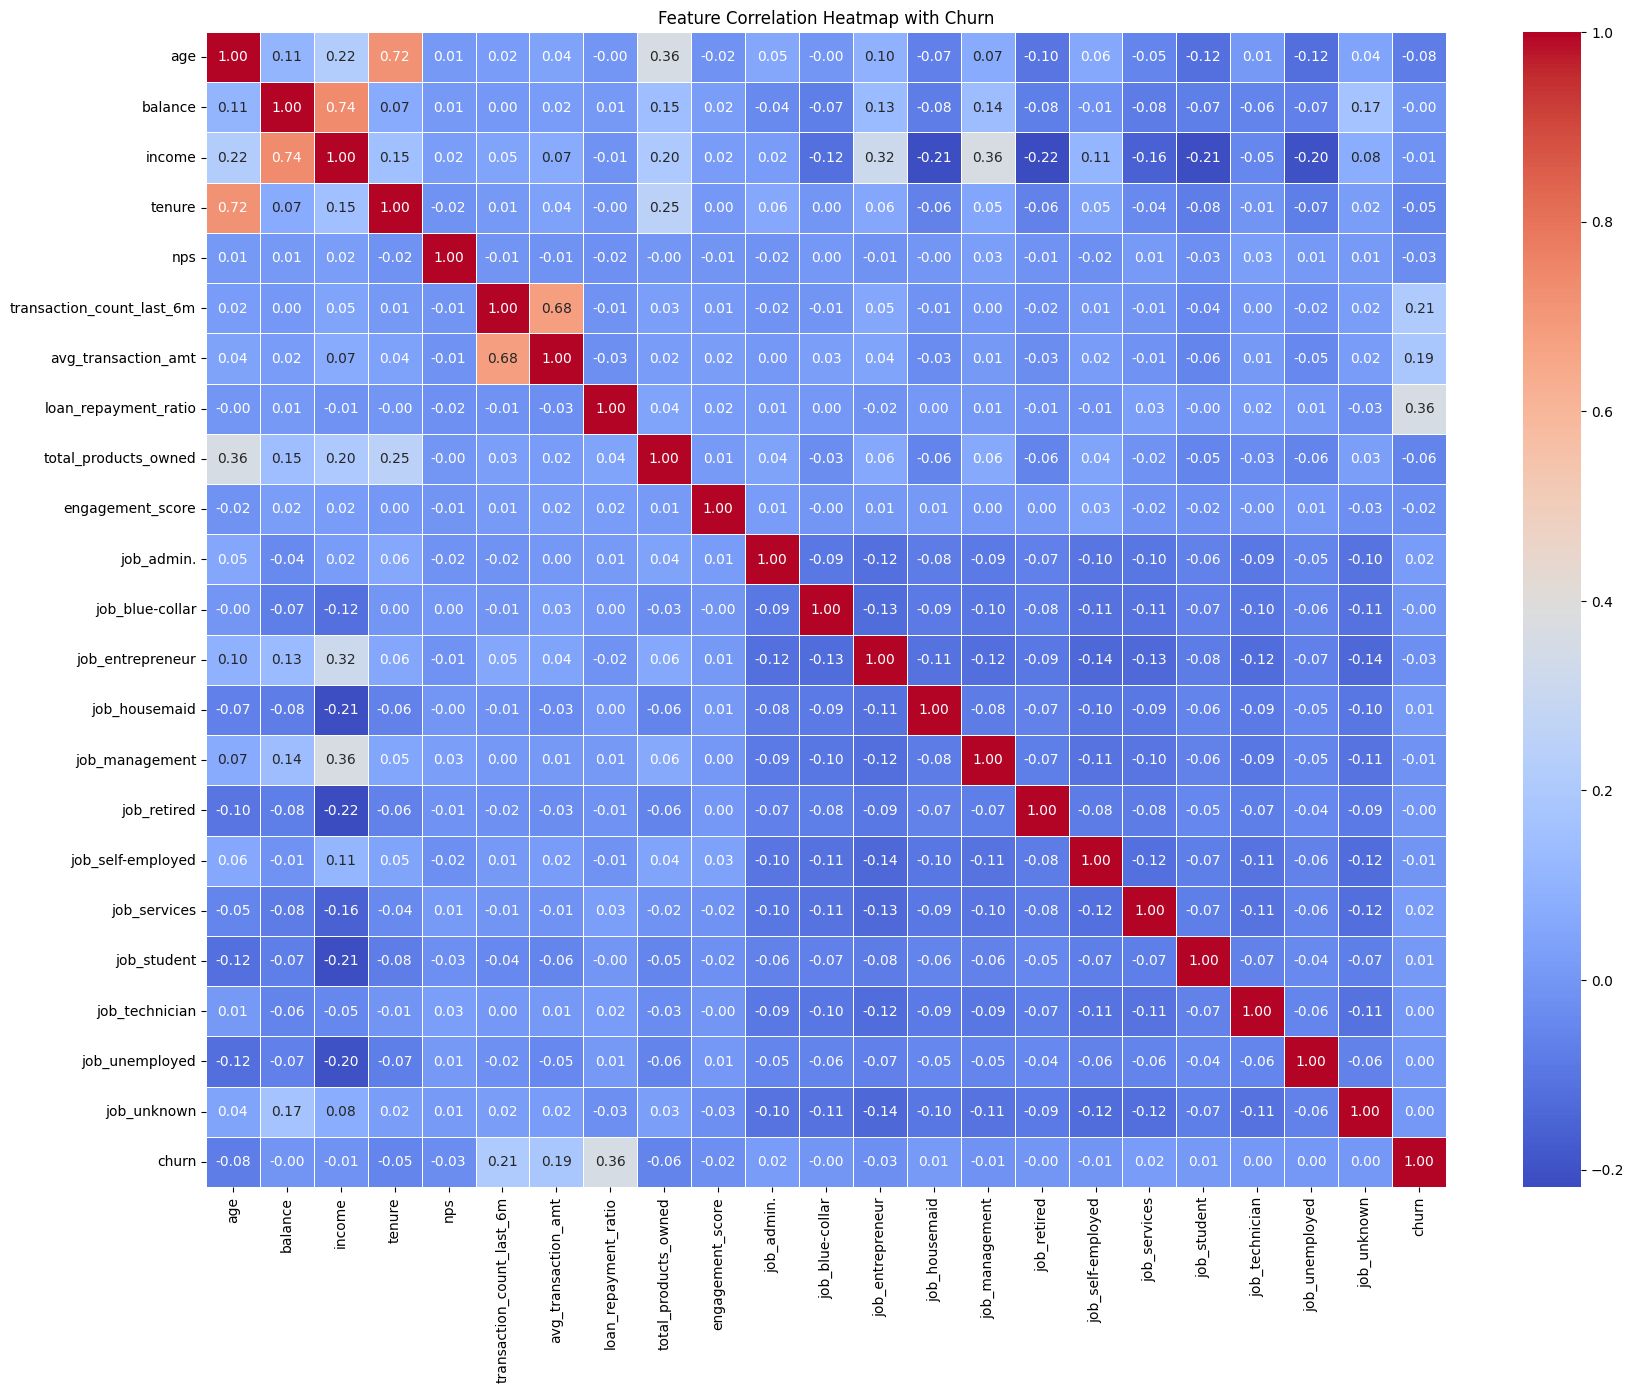

In [ ]:
correlation_matrix = customer_df[features + ["churn"]].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap with Churn")
plt.show()


In [189]:

churn_correlation = correlation_matrix["churn"].sort_values(ascending=False)
print(churn_correlation)

churn                        1.000000
loan_repayment_ratio         0.361541
transaction_count_last_6m    0.208942
avg_transaction_amt          0.187785
job_services                 0.019451
job_admin.                   0.015457
job_housemaid                0.010271
job_student                  0.008027
job_unemployed               0.003142
job_unknown                  0.002915
job_technician               0.000933
job_retired                 -0.001323
job_blue-collar             -0.001886
balance                     -0.004972
job_self-employed           -0.008073
job_management              -0.013465
income                      -0.014952
engagement_score            -0.023968
job_entrepreneur            -0.026171
nps                         -0.032375
tenure                      -0.053758
total_products_owned        -0.056585
age                         -0.075653
Name: churn, dtype: float64
